In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df_hc = pd.read_csv('train.csv', index_col=0)
df_hc.head()

,lepton_1_pT,lepton_1_eta,lepton_1_phi,lepton_2_pT,lepton_2_eta,lepton_2_phi,missing_energy_magnitude,missing_energy_phi,MET_rel,axial_MET,M_R,M_TR_2,R,MT2,S_R,M_Delta_R,dPhi_r_b,cos(theta_r1),class
0,0.841381,1.832647,-0.689286,0.781839,0.572864,1.577097,0.398978,-0.683847,0.001826,0.651397,0.865560,0.429017,0.439840,0.000000,0.796105,0.342497,0.461542,0.005710,0.0
1,0.663798,2.058290,0.681435,1.054036,0.575352,-1.001445,0.462154,-0.833411,0.199734,0.215158,0.949988,0.618046,0.577324,0.000000,0.962927,0.333800,1.455247,0.101246,0.0
2,1.792225,-1.099978,0.088109,0.573157,-0.472629,1.642084,1.203374,1.506731,0.457695,-0.640507,1.157024,1.585432,1.215963,0.000000,1.113292,0.645729,0.721326,0.613326,1.0
3,0.893018,0.297782,-1.274870,1.316164,1.593303,0.672115,0.307014,-1.189868,0.064561,0.430909,1.162625,0.548821,0.418897,0.163908,1.157707,0.298163,0.803802,0.038902,0.0
4,1.338997,0.350023,-1.518510,1.482963,-0.491807,0.340170,0.415071,-1.292034,0.240712,0.611775,1.307798,0.697804,0.473487,0.429977,1.287935,0.330327,0.717237,0.003147,1.0


In [4]:
df_hcc = df_hc.copy()

# Preprocessing

In [6]:
df_hcc.columns

Index(['lepton_1_pT', 'lepton_1_eta', 'lepton_1_phi', 'lepton_2_pT',
       'lepton_2_eta', 'lepton_2_phi', 'missing_energy_magnitude',
       'missing_energy_phi', 'MET_rel', 'axial_MET', 'M_R', 'M_TR_2', 'R',
       'MT2', 'S_R', 'M_Delta_R', 'dPhi_r_b', 'cos(theta_r1)', 'class'],
      dtype='object')

In [8]:
df_hcc.iloc[:,:5].shape

(3500000, 5)

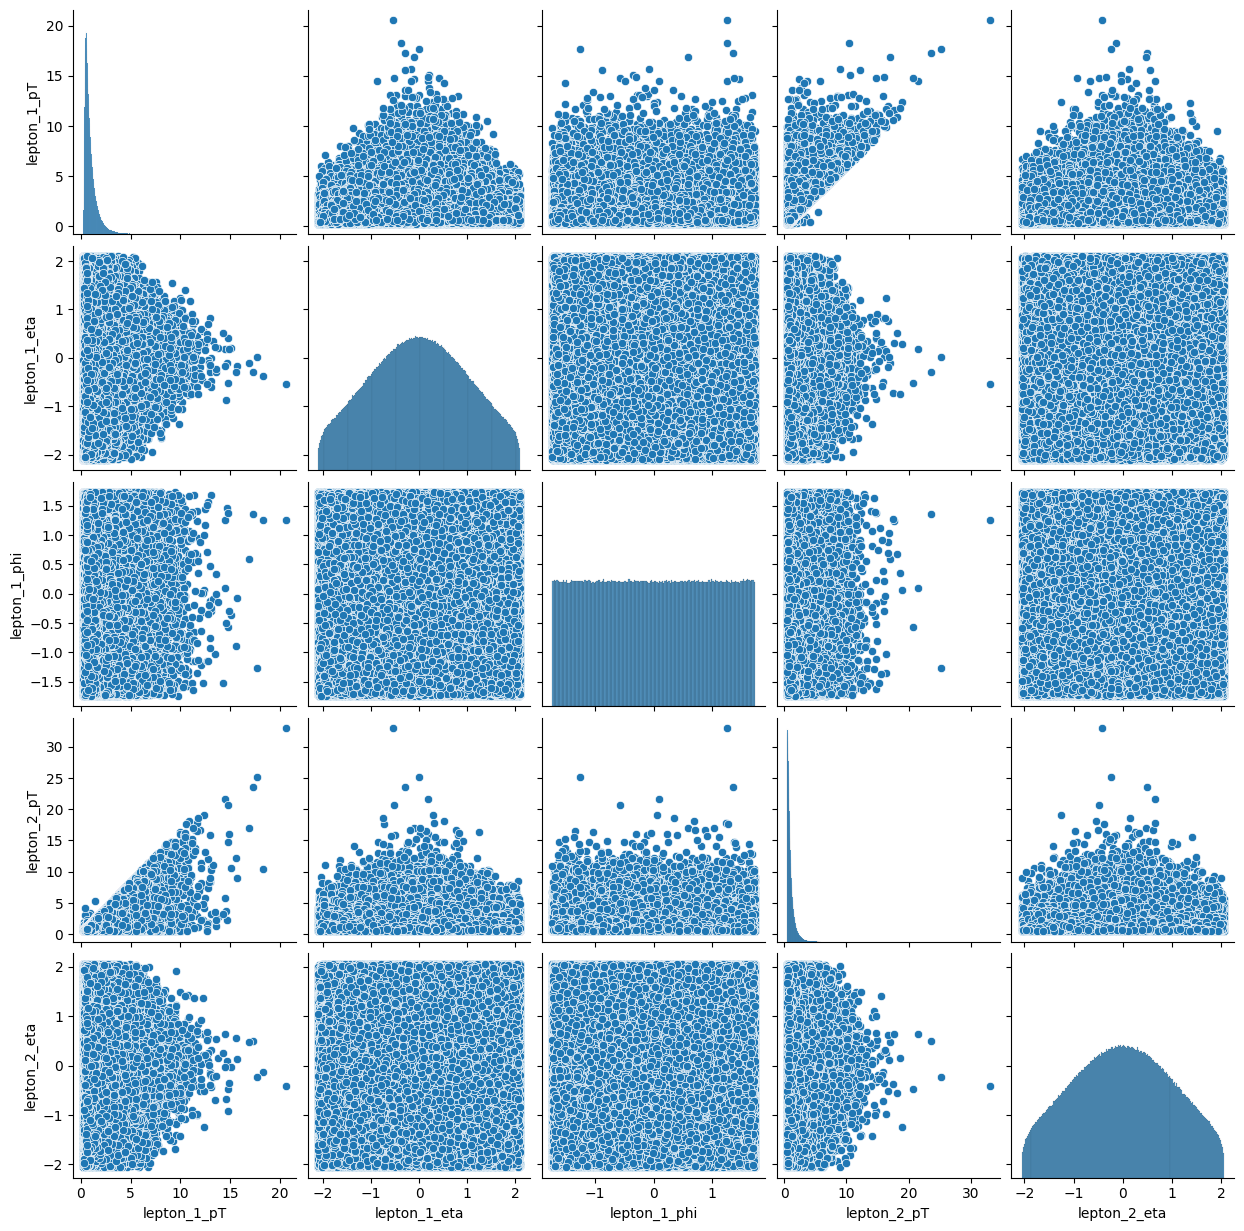

In [9]:
sns.pairplot(df_hcc.iloc[:,:5])

<AxesSubplot:xlabel='class', ylabel='lepton_1_pT'>

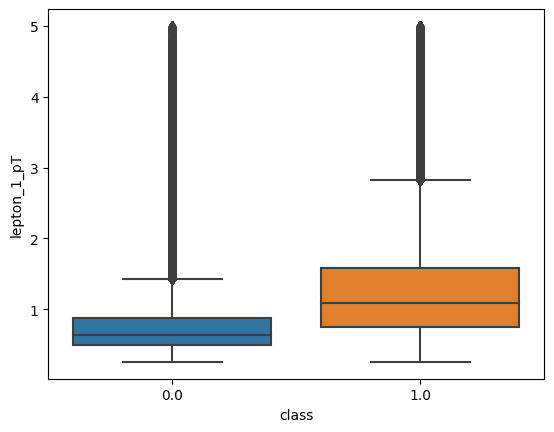

In [12]:
sns.boxplot(data=df_hcc[df_hcc['lepton_1_pT'] < 5], y='lepton_1_pT', x='class')

In [5]:
df_hcc=df_hcc[df_hcc['lepton_1_pT'] < 5]

In [6]:
df_hcc.shape

(3491438, 19)

# Split for Calculation

In [15]:
X, y = df_hcc.loc[:, df_hcc.columns != 'class'].to_numpy(dtype=np.float_), df_hcc['class'].to_numpy(dtype=np.float_)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [16]:
from sklearn.preprocessing import MinMaxScaler
mm_scaler = MinMaxScaler()
X_train = mm_scaler.fit_transform(X_train)
X_test = mm_scaler.transform(X_test)

# Model Training

#### Random Forest Model

In [30]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=160, n_jobs=-1)

In [31]:
model.fit(X_train ,y_train)

RandomForestClassifier(n_estimators=160, n_jobs=-1)

In [32]:
model.score(X_test, y_test)

0.8004419379969296

#### Gradient Boost Model

In [33]:
from sklearn.ensemble import HistGradientBoostingClassifier
# model_xg = HistGradientBoostingClassifier(l2_regularization=0.2)
# model_xg.fit(X_train, y_train)

HistGradientBoostingClassifier(l2_regularization=0.2)

In [40]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'learning_rate': (0.01, 0.1, 1, 10),
    'max_leaf_nodes': (3, 10, 30),
    'l2_regularization': (0.1, 0.2, 0.3, 0.4, 0.5)}

model_grid_search = GridSearchCV(HistGradientBoostingClassifier(), param_grid=param_grid,
                                 n_jobs=-1, cv=2, )
model_grid_search.fit(X_train, y_train)

GridSearchCV(cv=2, estimator=HistGradientBoostingClassifier(), n_jobs=-1,
             param_grid={'l2_regularization': (0.1, 0.2, 0.3, 0.4, 0.5),
                         'learning_rate': (0.01, 0.1, 1, 10),
                         'max_leaf_nodes': (3, 10, 30)})

In [41]:
print(model_grid_search.best_params_)
print(model_grid_search.best_estimator_)

{'l2_regularization': 0.5, 'learning_rate': 0.1, 'max_leaf_nodes': 30}
HistGradientBoostingClassifier(l2_regularization=0.5, max_leaf_nodes=30)


In [42]:
model_grid_search.score(X_test, y_test)

0.8022055369704191

In [44]:
model_xg = HistGradientBoostingClassifier(l2_regularization=model_grid_search.best_params_['l2_regularization'],
                                learning_rate=model_grid_search.best_params_['learning_rate'],
                                max_leaf_nodes=model_grid_search.best_params_['max_leaf_nodes'])
model_xg.fit(mm_scaler.fit_transform(X), y)

HistGradientBoostingClassifier(l2_regularization=0.5, max_leaf_nodes=30)

In [50]:
model.feature_importances_

array([0.10987304, 0.04724652, 0.03269169, 0.03738642, 0.04234704,
       0.03256939, 0.14524249, 0.03276543, 0.04845997, 0.08001275,
       0.05243717, 0.09244676, 0.03672791, 0.03156072, 0.04957446,
       0.04082546, 0.04066141, 0.04717137])

# Final Predictions 

In [45]:
X_t = pd.read_csv('test.csv', index_col=0).to_numpy(dtype=np.float_)
X_t = mm_scaler.transform(X_t)
# X_t, y_t = df_test.loc[:, df_test.columns != 'class'].to_numpy(dtype=np.float_), df_test['class'].to_numpy(dtype=np.float_)
output = pd.Series(model.predict(X_t), name='class')
output_xg = pd.Series(model_xg.predict(X_t), name='class')

In [46]:
output.to_csv('res.csv', index=True, index_label='Id')
output_xg.to_csv('res_xg.csv', index=True, index_label='Id')

In [47]:
y_ay = pd.read_csv('y_ayush.csv', index_col=0)
y_ay['class']
print(np.sum(output == y_ay['class'])/len(output))
print(np.sum(output_xg == y_ay['class'])/len(output_xg))

0.956098
0.972816
